In [1]:
import numpy as np
import gurobipy as grb
import matplotlib.pyplot as plt
import networkx as nx
import math
import pandas as pd
import keras
import multidict
from mip import *
import random
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import time

Using TensorFlow backend.
c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
X1 = []
Y1 = []
Y2 = []
latencyv = []
data_ann = []
data_ilp = []

In [3]:
N =6000 # Number of VNF
H = 140 #Number of Hosts
case = 4

In [4]:
start_time_ann = time.time()
classifier = Sequential()
classifier.add(Dense(output_dim=16, init='uniform', activation='relu', input_dim=9))
classifier.add(Dropout(p=0.1))
classifier.add(Dense(output_dim=16, init='uniform', activation='relu'))
classifier.add(Dropout(p=0.1))
classifier.add(Dense(output_dim=1, init='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=16, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  """
c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
c:\users\ishan\appdata\local\programs\python\python37\lib\

In [5]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev
def Average(lst):
    return sum(lst) / len(lst)

In [6]:
for loop in range(7):
    D = []
    acc = []
    ilp = []
    ann = []
    Xij = {}
    for epoch in range(case):
        # Randomly generating the variables
        host_capasity = {}   #Capacity of the Host Cj
        for h in range(H):
            host_capasity[h] = random.randint(10,800)

        host_bad = {}  #Bandwidth Required bij
        for n in range(N):
            for h in range(H):
                host_bad[n,h] = random.randint(5,10)

        network_req = {} #Requirement of the Network Ri
        for n in range(N):
            network_req[n] = random.randint(10,50);

        network_tol = {} #Maximum Tolerance Oi
        for n in range(N):
            network_tol[n] = random.randint(30,100);

        host_network_object = {} #Total Latency Lij
        for n in range(N):
            for h in range(H):
                host_network_object[n,h] = random.randint(5,100)

        host_network_capasity = {} #Bandwidth Capacity Qij
        for n in range(N):
            for h in range(H):
                host_network_capasity[n,h] = random.randint(50,100)

        variables, latency = grb.multidict(host_network_object)  # Division of the Latency into two dictionary

        start_time_ilp = time.time()

        m = grb.Model("VNF")  # Intialising the model
        X = m.addVars(variables,vtype=grb.GRB.BINARY,name="X")  #declaring the optimal variable

        # constraint 1:
        for h in range(H):
            hostCapasitySum = 0;
            for n in range(N):
                hostCapasitySum+=X[n,h] * network_req[n]
            m.addConstr(hostCapasitySum <=host_capasity[h])


        # constraint 2:
        for n in range(N):
            networkToleranceSum = 0;
            for h in range(H):
                networkToleranceSum+=X[n,h] * host_network_object[n,h]
            m.addConstr(networkToleranceSum<=network_tol[n])

        # constraint 3:
        for h in range(H):
            connectionSum = 0
            for n in range(N):
                connectionSum+=X[n,h]
            m.addConstr(connectionSum==1)

        # constraint 4:
        for n in range(N):
            networkCapasitySum =0 
            for h in range(H):
                networkCapasitySum+=X[n,h] * host_bad[n,h]
                m.addConstr(networkCapasitySum<=host_network_capasity[n,h])


        # Objective Function: 
        obj = 0;
        for h in range(H):
            for n in range(N):
                obj+=X[n,h] * host_network_object[n,h]
        m.setObjective(obj,grb.GRB.MINIMIZE )

        m.optimize()
        end_time_ilp = time.time()  
        for n in range(N):
            for h in range(H):
                Xij[n,h] = 0
        net = 0
        host = 0
        #Going through each column of the optimal data
        for variable in m.getVars():
            if host > H - 1 :
                host = 0
                net = net + 1
            #print(variable.varName + " = "+ str(variable.x))
            if(variable.x==1):
                print(variable.varName + " = "+ str(variable.x))
                D.append([epoch, host_capasity[host],host_network_capasity[net, host],
                           host_network_object[net, host],network_req[net],network_tol[net],
                           host_bad[net, host],net+1,host+1,variable.x])  
                Xij[net,host] = 1
            else:
                D.append([epoch, host_capasity[host],host_network_capasity[net, host],
                           host_network_object[net, host],network_req[net],network_tol[net],
                           host_bad[net,host],net+1,host+1,variable.x])
                Xij[net,host] = 0
            
            host = host + 1 
 
    df = pd.DataFrame(D)
    df.columns = ['Index','Host_cap','link_cap','latency','req','tol','band','Net','Host','value']
    Nu = len(df)
    s = Nu/case
    s = int(Nu - s)
    X_train = df.iloc[:s, :-1].values
    X_test = df.iloc[s:, :-1].values
    y_train = df.iloc[:s, -1].values
    y_test = df.iloc[s:, -1].values
    yij1 = df.iloc[:, 7:].values
  
    if(epoch == 0):
        classifier.fit(X_train, y_train, batch_size=100, nb_epoch=150)
    start_time_ann = time.time()
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred > 0.5)
    end_time_ann = time.time()
              
    lat_ann = {}
    i=0
    
    for n in range(N):
            for h in range(H):
                if(Xij[n,h] == 1):
                    ilp.append(host_network_capasity[n, h])
                    ann.append(host_network_capasity[n, h])
                    host_capasity[h] = host_capasity[h] - network_req[n]
                    host_network_capasity[n, h] = host_network_capasity[n, h] - host_bad[n, h]    
                if(y_pred[i] == [ True]):
                    lat_ann[n,h] = 1 * host_network_object[n,h]
                    ann.append(lat_ann[n,h])                    
                i = i + 1
    #function to identify the placement of the vnf
    for n in range(N):
        M = [0]*H
        for h in range(H):
            if host_network_object[n,h] > network_tol[n] or network_req[n] > host_network_capasity[n,h] or host_bad[n,h] > host_network_capasity[n,h]:
                M[h] = 0
            else:
                M[h] = 1
        k = M.index(np.amax(M))
        host_capasity[k] = host_capasity[k] - network_req[n]
        host_network_capasity[n,k] = host_network_capasity[n,k] - host_bad[n,k]


    dev1 = stdev(ann)#function to get standard deviation
    dev2 = stdev(ilp)
    Y1.append([end_time_ilp-start_time_ilp])
    Y2.append([end_time_ann-start_time_ann])
    latencyv.append((dev1-dev2)/dev1)
    data_ann.append(Average(ann))
    data_ilp.append(Average(ilp))
    X1.append([N])

    N = N + 1000

Using license file C:\Users\ishan\gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 606200 rows, 600000 columns and 32100000 nonzeros
Model fingerprint: 0xa43749c8
Variable types: 0 continuous, 600000 integer (600000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+02]
Found heuristic solution: objective 4226.0000000
Presolve removed 268081 rows and 223910 columns (presolve time = 11s) ...
Presolve removed 268081 rows and 223910 columns (presolve time = 15s) ...
Presolve removed 590272 rows and 223910 columns (presolve time = 20s) ...
Presolve removed 590624 rows and 223821 columns
Presolve time: 22.91s
Presolved: 15576 rows, 376179 columns, 1385447 nonzeros
Variable types: 0 continuous, 376179 integer (376090 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing 

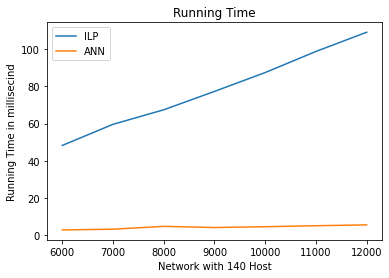

In [16]:
plt.plot(X1, Y1, label = "ILP") 
plt.plot(X1, Y2, label = "ANN") 
plt.xlabel('Network with 140 Host') 
plt.ylabel('Running Time in millisecind') 
# Give a title to the graph
plt.title('Running Time') 
  
# Show a legend on the plot 
plt.legend() 
 
plt.show() 

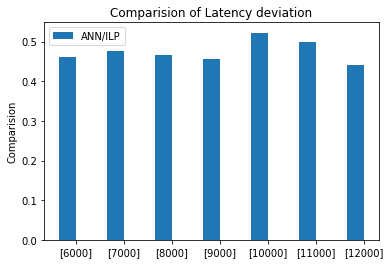

In [9]:
le = np.arange(len(latencyv))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(le - width/2, latencyv, width, label='ANN/ILP')
ax.set_ylabel('Comparision')
ax.set_title('Comparision of Latency deviation')
ax.set_xticks(le)
ax.set_xticklabels(X1)
ax.legend()

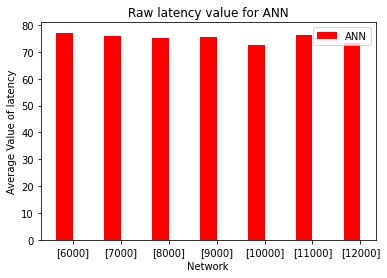

In [14]:
le = np.arange(len(data_ann))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(le - width/2, data_ilp, width, label='ANN', color=['red'])
ax.set_ylabel('Average Value of latency')
ax.set_title('Raw latency value for ANN')
ax.set_xticks(le)
ax.set_xticklabels(X1)
ax.set_xlabel('Network')
ax.legend()

c:\users\ishan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


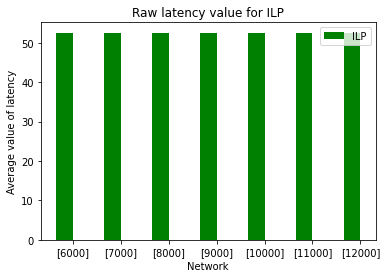

In [15]:
le = np.arange(len(data_ilp))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(le - width/2, data_ann, width, label='ILP', color=['green'])
#rects2 = ax.bar(le + width/2, ann, width, label='ANN')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average value of latency')
ax.set_title('Raw latency value for ILP')
ax.set_xticklabels(X1)
ax.set_xticks(le)
ax.set_xlabel('Network')
ax.legend()